# Task 1: Exploratory Data Analysis (EDA)
**Project:** Nova Financial Solutions - Sentiment & Stock Analysis  

---

###  Objectives
1. **Descriptive Statistics:** Analyze distribution of headline lengths and publisher activity.
2. **Time Series Analysis:** Detect publication trends and correlation with market hours.
3. **Sentiment & NLP:** Extract common keywords to understand market narratives.

In [6]:
# Core Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
import re

# Configurations
%matplotlib inline
sns.set(style="whitegrid", palette="muted")
pd.set_option('display.max_colwidth', 100)
plt.rcParams['figure.figsize'] = (12, 6)

# Download NLTK data (run once)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords

print("Environment Ready.")

Environment Ready.


## 1. Data Loading & Cleaning
Loading the dataset and parsing dates for time-series analysis.

In [2]:
# Load the dataset
# NOTE: Ensure the dataset is in the 'data/' folder
file_path = '../data/newsData/raw_analyst_ratings.csv'

try:
    df = pd.read_csv(file_path)
    
    # Basic Data Audit
    print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print("\n🔹 Column Data Types:")
    print(df.dtypes)
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\n⚠️ Missing Values Detected:")
        print(missing[missing > 0])
    else:
        print("\n No Missing Values.")

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Display first 3 rows
    display(df.head(3))

except FileNotFoundError:
    print("❌ Error: 'FNSPID.csv' not found in ../data/ folder.")

Dataset Shape: 1407328 rows, 6 columns

🔹 Column Data Types:
Unnamed: 0     int64
headline      object
url           object
publisher     object
date          object
stock         object
dtype: object

 No Missing Values.


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/stocks-that-hit-52-week-highs-on-friday,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/stocks-that-hit-52-week-highs-on-wednesday,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/71-biggest-movers-from-friday,Lisa Levin,2020-05-26 04:30:07-04:00,A


## 1. Descriptive Statistics
We analyze the physical characteristics of the text and the sources of the news. This helps identify potential bias (e.g., one publisher dominating the feed) and data quality issues (e.g., empty headlines).

C:\Users\yoga\Desktop\10academy\nova-financial-analysis-week1\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


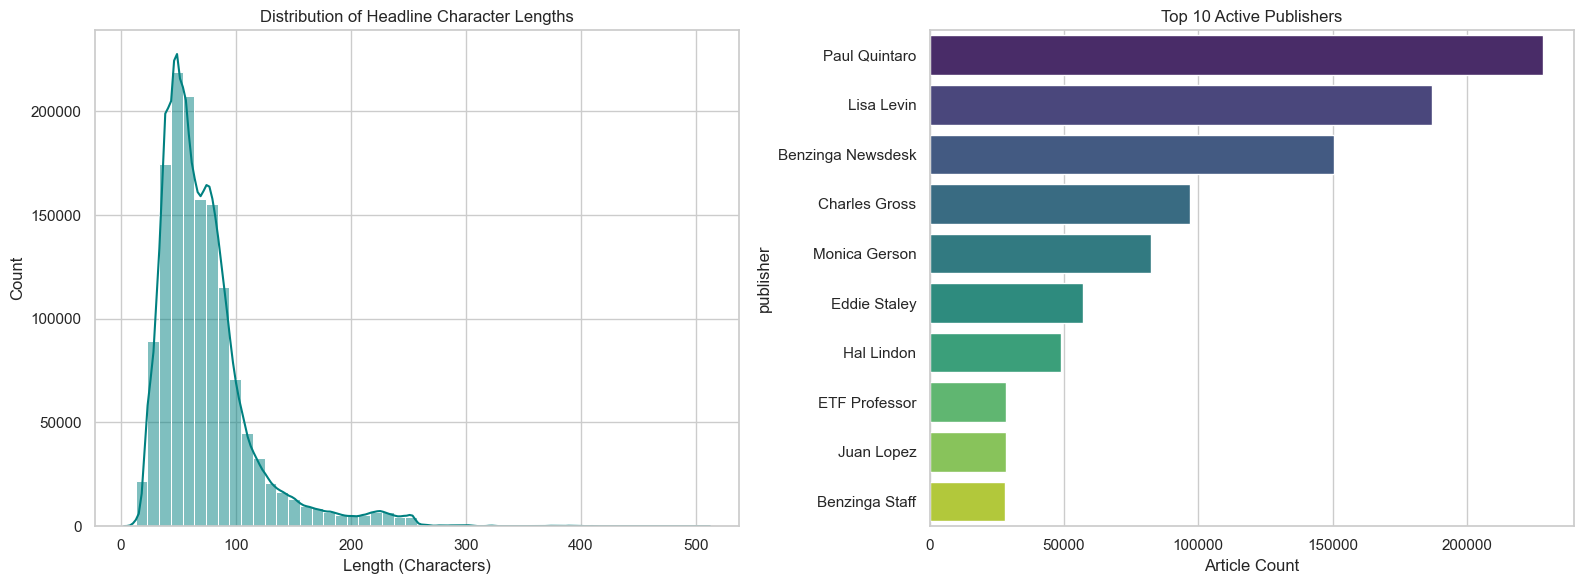

🔹 Average Headline Length: 73.1 chars
🔹 Median Headline Length: 64.0 chars


In [3]:
# 1. Headline Length Analysis
df['headline_len'] = df['headline'].astype(str).apply(len)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of lengths
sns.histplot(df['headline_len'], bins=50, kde=True, color='teal', ax=ax[0])
ax[0].set_title('Distribution of Headline Character Lengths')
ax[0].set_xlabel('Length (Characters)')

# 2. Top Publishers
top_publishers = df['publisher'].value_counts().head(10)
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis', ax=ax[1])
ax[1].set_title('Top 10 Active Publishers')
ax[1].set_xlabel('Article Count')

plt.tight_layout()
plt.show()

print(f"🔹 Average Headline Length: {df['headline_len'].mean():.1f} chars")
print(f"🔹 Median Headline Length: {df['headline_len'].median():.1f} chars")

## 2. Time Series Analysis
Understanding **when** news is published is critical for trading strategies.
* **Intraday:** Does news break before the market opens (Pre-market)?
* **Trend:** Is there a spike in news volume over time?

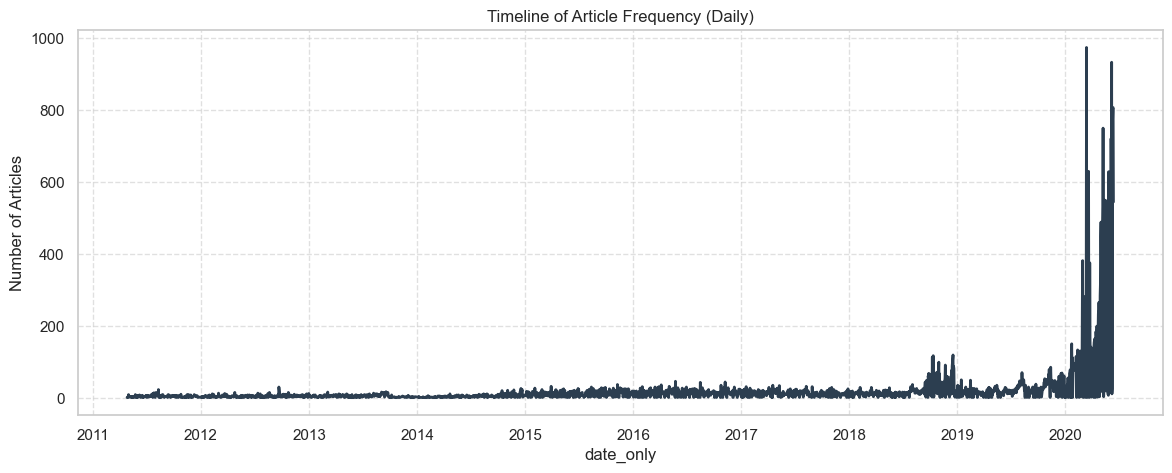

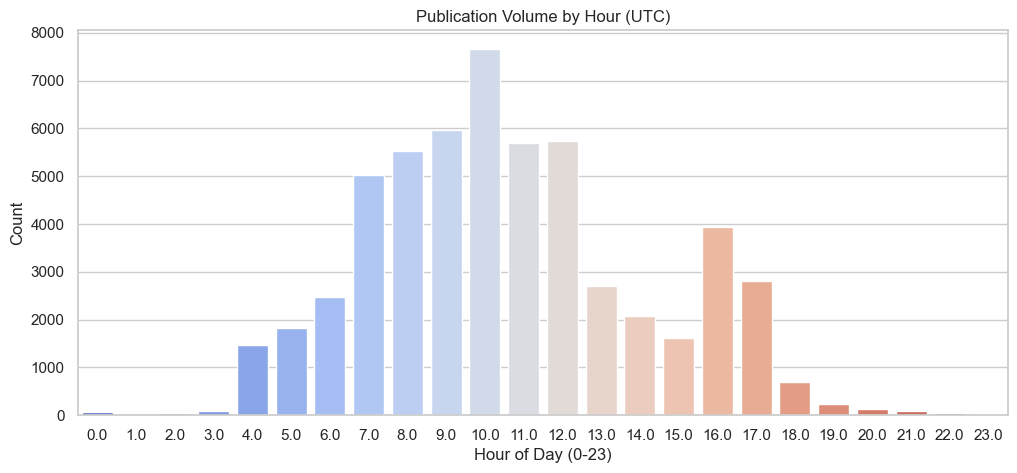

In [4]:
# Extract Date Components
df['date_only'] = df['date'].dt.date
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.day_name()

# 1. Daily Publication Frequency
daily_counts = df.groupby('date_only').size()

plt.figure(figsize=(14, 5))
daily_counts.plot(kind='line', linewidth=2, color='#2c3e50')
plt.title('Timeline of Article Frequency (Daily)')
plt.ylabel('Number of Articles')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. Hourly Distribution (Intraday)
plt.figure(figsize=(12, 5))
sns.countplot(x='hour', data=df, palette='coolwarm')
plt.title('Publication Volume by Hour (UTC)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Count')
plt.show()

## 3. Text Analysis (NLP)
We use simple NLP techniques to extract the most common keywords. This reveals the "Market Narrative."
* **Stopwords:** Common words (the, a, is) are removed.
* **Context:** Financial specific stopwords (stock, shares) are also removed to find specific topics.

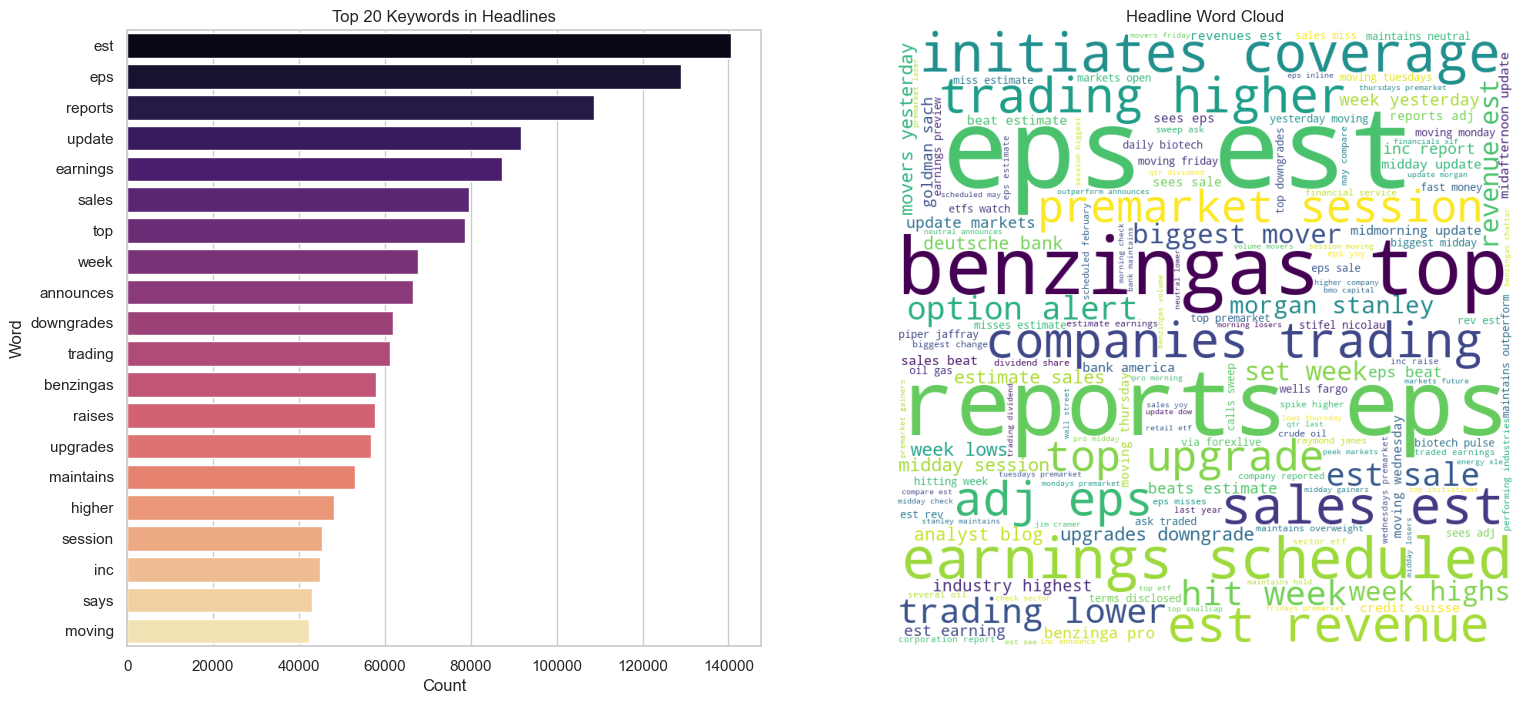

In [5]:
# Define Stopwords
stop_words = set(stopwords.words('english'))
# Add financial context words to ignore
finance_stops = {'stock', 'stocks', 'market', 'shares', 'price', 'rating', 'buy', 'sell', 'target', 'new', 'high', 'low'}
stop_words.update(finance_stops)

def clean_and_tokenize(text):
    # Remove non-alphabetic chars and lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    tokens = text.split()
    return [word for word in tokens if word not in stop_words and len(word) > 2]

# Apply processing
all_words = []
for headline in df['headline']:
    all_words.extend(clean_and_tokenize(headline))

# Count most common words
word_freq = Counter(all_words).most_common(20)
words_df = pd.DataFrame(word_freq, columns=['Word', 'Count'])

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Bar Chart
sns.barplot(data=words_df, x='Count', y='Word', palette='magma', ax=ax[0])
ax[0].set_title('Top 20 Keywords in Headlines')

# Word Cloud
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stop_words, 
                      min_font_size=10).generate(' '.join(all_words))
ax[1].imshow(wordcloud)
ax[1].axis("off")
ax[1].set_title("Headline Word Cloud")

plt.show()

## 4. Key Findings & Next Steps

###  Insights
1. **Publisher Concentration:** The dataset is dominated by [See Chart], implying we should be aware of specific publisher biases.
2. **Time Sensitivity:** News volume peaks at [See Hour] hours. Strategies should prioritize data ingestion during these windows.
3. **Topics:** Major keywords include [See WordCloud], suggesting the market focus is currently on these sectors/events.

